<!-- ## Paper and data:

https://zenodo.org/records/13357926

https://www.nature.com/articles/s41563-024-02016-6

using stem ae and shuyu's affine transform code -->


In [1]:
%load_ext autoreload
%autoreload 2

import tqdm
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('/home/xz498/NaCl_STEM/m3_learning/src/')
sys.path.append('/home/xz498/NaCl_STEM/Gaussian_Sampler/')
# sys.path.append('/home/xz498/anaconda3/envs/nacl_stem/lib/python3.10/site-packages/m3_learning/m3_learning/src')

from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler
from Gaussian_Sampler.models.base_model import Averaging_Loss_AE
import py4DSTEM

from m3_learning.nn.STEM_AE.Viz import Viz
from m3_learning.viz.printing import printer

2024-11-25 17:30:21.295454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 17:30:21.320329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 17:30:21.330926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 17:30:21.342039: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 17:30:22.165512: W tensorflow/compiler/tf2

In [2]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import numpy as np

plt.clf();plt.clf()
def get_theta(rotation):
    """_summary_

    Args:
        rotation (array-like): (n,2,3) affine matrix reshapeed into (n,6)

    Returns:
        float: _description_
    """    
    acos = np.arccos(rotation[:,0])
    asin = np.arcsin(rotation[:,1])
    theta = asin.copy()

    # asin(+), acos(+) means the angle is accurate
    # asin(-), acos(-) means 3rd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] *= -1 
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] += -np.pi
    # asin(+), acos(-) means 2nd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] *= -1
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] += np.pi/2
    
    return theta

def affines(affines,
            shape_=[255, 256, 256, 256], 
            sc=True,
            sh=True,
            trans=True,
            rot=True,
            name="",
            labelfigs_ = False,
            scalebar_ = None,
            printer = None,
            **kwargs):
    """Plots the embeddings

    Args:
        embedding (tuple of array-like): (scale_shear,rotation,translation) matrices from AffineTransform class.
                                         If not calculated, put None.
        # mod (int, optional): defines the number of columns in the figure. Defaults to 4.
        channels (bool, optional): specific channels to plot. Defaults to False.
        scalebar_ (dict, optional): add the scalebar. Defaults to None.
        shape_ (list, optional): shape of the initial image. Defaults to [265, 256, 256, 256].
        name (str, optional): filename. Defaults to "".
        channels (bool, optional): _description_. Defaults to False.
        labelfigs_ (bool, optional): _description_. Defaults to False.
        add_scalebar (_type_, optional): _description_. Defaults to None.
        printer (_type_, optional): _description_. Defaults to None.
    """        

    scale,shear,rotation,translation = affines

    # # sets the channels to use in the object
    # if channels is None:
    #     channels = range(7)

    num_plots = 2*sh + 2*sc + 2*trans + rot
    # builds the figure
    fig, axs = layout_fig(num_plots, mod=2, **kwargs)

    i=0
    # translation
    if trans:
        imagemap(axs[i], translation[:,2].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], translation[:,5].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('translation x')
        axs[i+1].set_title('translation y')
        i+=2
    # scale_shear
    if sc:
        imagemap(axs[i], scale[:,0].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], scale[:,4].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('scale x')
        axs[i+1].set_title('scale y')
        i+=2
    if sh:
        imagemap(axs[i], shear[:,1].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear x
        imagemap(axs[i+1], shear[:,3].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear y
        axs[i].set_title('shear x')
        axs[i+1].set_title('shear y')
        i+=2
    # rotation
    if rot:
        theta = get_theta(rotation)
        # lim = abs(theta.mean())+abs(3*theta.std())
        imagemap(axs[i], theta.reshape(shape_[-4], shape_[-3]), 
                 divider_=False,**kwargs) # rotation angle
        axs[i].set_title('rotation')

    # adds labels to the figure
    if labelfigs_:
        for i, ax in enumerate(axs):
            labelfigs(ax, i)

    # adds the scalebar
    if scalebar_ is not None:
        add_scalebar(axs.flatten()[-1], scalebar_)

    # prints the image
    if printer is not None:
        printer.savefig(fig,
            f'{name}_affine_maps', tight_layout=False)
        
    # plt.close(fig)
    # return fig, ax


<Figure size 640x480 with 0 Axes>

## Load Data

In [3]:
# Data
file_path = '/home/xz498/NaCl_STEM/Data/'
data_id = 'Hydrated_NaCl_CL_2p7'
step_size = 20 #nm
CL_data = 2.7
file_data = file_path + 'Hydrated_NaCl_CL_2p7.dm4' 

# Calibrant
file_path_Au_cal = file_path +'Calibrant_Hydrated_NaCl_CL_2p7.dm4'
step_size_Au = 10 # nm
CL_calibrant = 2.7

# In case calibration was not taken in a a similar camera length 
CL_correction = CL_calibrant/CL_data 

# Output folder
file_path_output = '/home/xz498/NaCl_STEM/Results/'+data_id+'/'
if os.path.exists(file_path_output):
    print("filePath already exist.")
else:
    os.mkdir(file_path_output)

filePath already exist.


In [4]:
# Decided based on a pre binning testing 
bin_factor = 4

In [5]:
AcquisitionBinning = 4
binProbe = AcquisitionBinning*bin_factor

In [6]:
'''
Real space to q space rotation. 
The angle was experimentaly measured.
rotation_calibration_theta= -0.118682 
in radians, -6.8 degrees 
'''
rotation_calibration = -6.8

In [10]:
from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler
from Gaussian_Sampler.models.base_model import Averaging_Loss_AE
from Gaussian_Sampler.data.datasets import Py4DSTEM_Dataset

dataset = Py4DSTEM_Dataset(file_data, binfactor=bin_factor, 
                        #    block=15, 
                           center=(88,92),  
                           hot_px_threshold=0.8, 
                           log=False, 
                           standard=False,
                           minmax=True, 
                           stdv_thresh=20.
                           )

Loading dataset...


100%|██████████| 10000/10000 [00:08<00:00, 1208.40it/s]


Preprocessing data...
Removing hot pixels...
Total hot pixels = 14
Centering data...
Thresholding 20.0 standard deviations...
Removing NaNs...
Minmax scaling data...
Computing to np array...
Done.


### misc

In [ ]:
###

In [8]:
# plt.hist(dataset.log_data.flatten(),bins=50)
# plt.show()

In [9]:
# plt.clf();plt.clf()
# plt.imshow(dataset.log_data.mean(axis=(1,2)).reshape(100,100))
# for num in np.unique(wh[:,0]):
#     plt.plot(num%100, num//100, 'ro', markerfacecolor='none')
# plt.show()
    

In [10]:
# j=0
# plt.clf();plt.clf()
# for num in np.unique(wh[:,0]):
#     print(num)
#     plt.imshow(dataset.log_data[num])
#     while j<len(wh) and wh[j,0]==num:
#         plt.plot(wh[j,2], wh[j,1], 'ro', markerfacecolor='none')
#         j+=1
#     plt.show();

<Figure size 640x480 with 0 Axes>

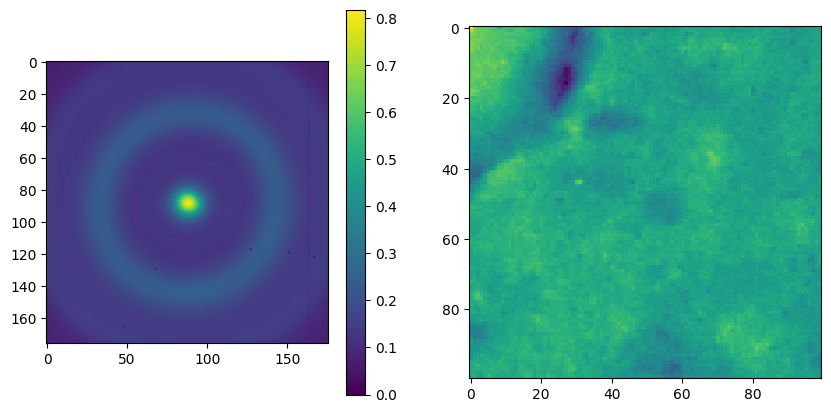

In [45]:
plt.clf()
fig, ax = plt.subplots(1,2, figsize=(10,5))
a = ax[0].imshow(dataset.log_data.mean(axis=0))
ax[1].imshow(dataset.log_data.mean(axis=(1,2)).reshape(100,100))
plt.colorbar(a)
plt.show()

### pca

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
import holoviews as hv
import panel as pn
hv.extension('bokeh')
pn.extension('bokeh')
a_, b_, x_, y_ = dataset.shape
data = dataset.log_data.reshape(a_, b_, x_, y_)

slider_x = pn.widgets.IntSlider(name='x', start=0, end=x_-1, step=1)
slider_y = pn.widgets.IntSlider(name='y', start=0, end=y_-1, step=1)
slider_a = pn.widgets.IntSlider(name='a', start=0, end=a_-1, step=1)
slider_b = pn.widgets.IntSlider(name='b', start=0, end=b_-1, step=1)

@pn.depends(x=slider_x, y=slider_y)
def update_realspace_slice(x, y):
    return hv.Image(data[:,:, x, y],
                    bounds=(0, 0, a_, b_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Realspace Slice')

@pn.depends(a=slider_a, b=slider_b)
def update_diffraction_slice(a, b):
    return hv.Image(data[a, b], 
                    bounds=(0, 0, x_, y_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Diffraction Slice')

mean_realspace = hv.Image(data.mean(axis=(2,3)).T, 
                          bounds=(0, 0, a_, b_)
                          ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)
mean_diffraction = hv.Image(data.mean(axis=(0,1)), 
                            bounds=(0, 0, x_, y_)
                            ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)

dmap_realspace = hv.DynamicMap(update_realspace_slice)
dmap_diffraction = hv.DynamicMap(update_diffraction_slice)

def plot_red_dot(x, y): 
    return hv.Points([(x, y)]).opts(color='red', size=3,
                           aspect='equal',)

@pn.depends(x=slider_x, y=slider_y)
def update_diffraction_dot(x, y): 
    return plot_red_dot(x, y)

@pn.depends(a=slider_a, b=slider_b)
def update_realspace_dot(a, b): 
    return plot_red_dot(a, b)

dmap_realspace_dot = hv.DynamicMap(update_realspace_dot)
dmap_diffraction_dot = hv.DynamicMap(update_diffraction_dot)

layout = pn.Column(
    pn.Row(slider_x, slider_y),
    pn.Row(slider_a, slider_b),
    
    
    pn.panel((mean_realspace * dmap_realspace_dot + \
        mean_diffraction * dmap_diffraction_dot).opts(shared_axes=False)),
    
    pn.panel((dmap_realspace * dmap_realspace_dot + \
        dmap_diffraction * dmap_diffraction_dot).opts(shared_axes=False))
)


In [ ]:
import holoviews as hv
import panel as pn
hv.extension('bokeh')
pn.extension('bokeh')
a_, b_, x_, y_ = dataset.shape
data = dataset.log_data.reshape(a_, b_, x_, y_)

slider_x = pn.widgets.IntSlider(name='x', start=0, end=x_-1, step=1)
slider_y = pn.widgets.IntSlider(name='y', start=0, end=y_-1, step=1)
slider_a = pn.widgets.IntSlider(name='a', start=0, end=a_-1, step=1)
slider_b = pn.widgets.IntSlider(name='b', start=0, end=b_-1, step=1)

def update_realspace_slice(x, y):
    return hv.Image(data[:,:, x, y],
                    bounds=(0, 0, a_, b_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Realspace Slice')

def update_diffraction_slice(a, b):
    return hv.Image(data[a, b], 
                    bounds=(0, 0, x_,y_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Diffraction Slice')

mean_realspace = hv.Image(data.mean(axis=(2,3)).T, 
                          bounds=(0, 0, a_, b_)
                          ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)
mean_diffraction = hv.Image(data.mean(axis=(0,1)), 
                            bounds=(0, 0, x_, y_)
                            ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)

dmap_realspace = hv.DynamicMap(pn.bind(update_realspace_slice, x=slider_x, y=slider_y))
dmap_diffraction = hv.DynamicMap(pn.bind(update_diffraction_slice, a=slider_a, b=slider_b))

def plot_red_dot(x, y): 
    return hv.Points([(x, y)]).opts(color='red', size=3,
                           aspect='equal',)

def update_diffraction_dot(x, y): 
    return plot_red_dot(x, y)

def update_realspace_dot(a, b): 
    return plot_red_dot(a, b)


dmap_realspace_dot = hv.DynamicMap(pn.bind(update_realspace_dot, a=slider_a, b=slider_b))
dmap_diffraction_dot = hv.DynamicMap(pn.bind(update_diffraction_dot, x=slider_x, y=slider_y))

layout = pn.Column(
    pn.Row(slider_x, slider_y),
    pn.Row(slider_a, slider_b),
    
    (mean_realspace * dmap_realspace_dot + \
    mean_diffraction * dmap_diffraction_dot).opts(shared_axes=False),
    
    (dmap_realspace * dmap_realspace_dot + \
    dmap_diffraction * dmap_diffraction_dot).opts(shared_axes=False)
)

layout


In [ ]:
from m3_learning.viz.layout import layout_fig, add_colorbar
 
plt.clf();plt.clf()
fig,ax = plt.subplots(2,4, figsize=(11,5))
ax=ax.flatten()
fig.suptitle('processed')

a=ax[-1].imshow(dataset.log_data.mean(axis=(1,2)).reshape(100,100))
add_colorbar(ax[-1], a)
for i,n in enumerate([20,255,954,2354,3845,4509,7039]):
# for i in range(20):
    x_,y_ = n//100, n%100
    a=ax[i].imshow(dataset.log_data[n,:,:])
    add_colorbar(ax[i], a)
    ax[i].set_title(f"({x_},{y_})")
    ax[-1].plot(y_,x_, 'ro', markerfacecolor='none')
    fig.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=32)

output = pca.fit_transform(dataset.log_data.reshape(dataset.log_data.shape[0],-1))

In [ ]:
import matplotlib.pyplot as plt
pca = PCA(n_components=50)
# Create a scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.clf();plt.clf()
fig,axs = plt.subplots(5,5,figsize=(15,12))
axs = axs.flatten()
fig.suptitle('pca components/explained variance ratio')
for i in range(25):
    a=axs[i].imshow(pca.components_[i].reshape(dataset.log_data.shape[1],
                                               dataset.log_data.shape[2]))
    add_colorbar(axs[i], a)
    axs[i].set_title(f"{i}: {pca.explained_variance_ratio_[i]:.2e}")
fig.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.clf();plt.clf()
fig,axs = plt.subplots(5,5,figsize=(15,12))
axs = axs.flatten()
fig.suptitle('transformed (projected)')
for i in range(25):
    a=axs[i].imshow(output[:,i].reshape(100,100))
    add_colorbar(axs[i], a)
    axs[i].set_title(f"{i}: {pca.explained_variance_ratio_[i]:.2e}")
fig.tight_layout()
plt.show()

In [ ]:
output[:, :10] = 0
recon = pca.inverse_transform(output)

In [ ]:
from m3_learning.viz.layout import layout_fig, add_colorbar
 
plt.clf();plt.clf()
# min_, max_ = recon.min(), recon.max()
fig,ax = plt.subplots(2,4, figsize=(10,5))
ax=ax.flatten()
fig.suptitle('reconstructed')

a=ax[-1].imshow(recon.mean(axis=(-1)).reshape(100,100))
add_colorbar(ax[-1], a)
for i,n in enumerate([20,255,954,2354,3845,4509,7039]):
# for i in range(20):
    x_,y_ = n//100, n%100
    a=ax[i].imshow(recon[n].reshape(176,176), vmin=0.0, vmax=0.05)
    add_colorbar(ax[i], a)
    ax[i].set_title(f"({x_},{y_})")
    ax[-1].plot(y_,x_, 'ro', markerfacecolor='none')

fig.tight_layout()
fig

## Simple Model

### shallow model, no pool, k5

In [8]:
from Gaussian_Sampler.models.affine_AE import Affine_AE_2D, Affine_Transform, Affine_AE_2D_module
from m3_learning.nn.STEM_AE import STEM_AE

# try with and without interpolation
model = Affine_AE_2D(device='cuda:3',
                     sampler=None,
                     sampler_kwargs={},
                     collate_fn=None,
                     
                     affine_encoder = STEM_AE.Encoder,
                     affine_encoder_kwargs = { 'original_step_size': [176,176], 
                                               'pooling_list': [], 
                                               'embedding_size': 6, # translation, rotation, xscale, yscale, xshear, yshear,
                                               'conv_size': 128,
                                               'kernel_size': 5,
                                               },
                     
                     affine_module = Affine_Transform,
                     affine_kwargs = {  "scale": True,
                                        "shear": True,
                                        "rotation": True,
                                        "translation": True,
                                        "Symmetric": True,
                                        "mask_intensity": False,
                                        "scale_limit": 1.,
                                        "shear_limit": 1.,
                                        "rotation_limit": 3.1415,
                                        "trans_limit": 1.,
                                        "adj_mask_para": 0  
                                        },
                     
                     encoder = STEM_AE.Encoder,
                     encoder_kwargs = { 'original_step_size': [176,176], 
                                        'pooling_list': [], 
                                        'embedding_size': 64, # translation, rotation, xscale, yscale, xshear, yshear,
                                        'conv_size': 128,
                                        'kernel_size': 5,
                                        },
                
                    decoder = STEM_AE.Decoder,
                    decoder_kwargs = { 'original_step_size': [176,176], 
                                        'upsampling_list': [], 
                                        'embedding_size': 64, 
                                        'conv_size': 128,
                                        'kernel_size': 5,
                                        },
                    autoencoder = Affine_AE_2D_module,
                     
                  #    # STEM AE kwargs:
                  #    encoder_step_size=[176, 176],
                  #    pooling_list=[4],
                  #    decoder_step_size=[22, 22],
                  #    upsampling_list=[8],
                  #    embedding_size=32,
                  #    conv_size=128,
                  #   #  device='cuda:1',
                  #    learning_rate=3e-5
                    )

In [66]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs=2,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/0_pool_rand_k5_/",
        batch_size=32,
)

  3%|▎         | 10/313 [00:08<04:04,  1.24it/s]


_LinAlgError: linalg.inv: (Batch element 19): The diagonal element 2 is zero, the inversion could not be completed because the input matrix is singular.

### shallow model, no pool 7k

In [29]:
from Gaussian_Sampler.models.affine_AE import Affine_AE_2D, Affine_Transform, Affine_AE_2D_module
from m3_learning.nn.STEM_AE import STEM_AE

# try with and without interpolation
model = Affine_AE_2D(device='cuda:3',
                     sampler=None,
                     sampler_kwargs={},
                     collate_fn=None,
                     
                     affine_encoder = STEM_AE.Encoder,
                     affine_encoder_kwargs = { 'original_step_size': [176,176], 
                                               'pooling_list': [], 
                                               'embedding_size': 6, # translation, rotation, xscale, yscale, xshear, yshear,
                                               'conv_size': 128,
                                               'kernel_size': 7,
                                               },
                     
                     affine_module = Affine_Transform,
                     affine_kwargs = {  "scale": True,
                                        "shear": True,
                                        "rotation": True,
                                        "translation": True,
                                        "Symmetric": True,
                                        "mask_intensity": False,
                                        "scale_limit": 1.,
                                        "shear_limit": 1.,
                                        "rotation_limit": 3.1415,
                                        "trans_limit": 1.,
                                        "adj_mask_para": 0  
                                        },
                     
                     encoder = STEM_AE.Encoder,
                     encoder_kwargs = { 'original_step_size': [176,176], 
                                        'pooling_list': [], 
                                        'embedding_size': 64, # translation, rotation, xscale, yscale, xshear, yshear,
                                        'conv_size': 128,
                                        'kernel_size': 7,
                                        },
                
                    decoder = STEM_AE.Decoder,
                    decoder_kwargs = { 'original_step_size': [176,176], 
                                        'upsampling_list': [], 
                                        'embedding_size': 64, 
                                        'conv_size': 128,
                                        'kernel_size': 7,
                                        },
                    autoencoder = Affine_AE_2D_module,
                     
                  #    # STEM AE kwargs:
                  #    encoder_step_size=[176, 176],
                  #    pooling_list=[4],
                  #    decoder_step_size=[22, 22],
                  #    upsampling_list=[8],
                  #    embedding_size=32,
                  #    conv_size=128,
                  #   #  device='cuda:1',
                  #    learning_rate=3e-5
                    )

In [30]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs=15,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/0_pool_rand_k7/",
        batch_size=32,
)

100%|██████████| 313/313 [06:34<00:00,  1.26s/it]


Epoch: 000/015 | Train Loss: 0.0007
.............................


100%|██████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch: 001/015 | Train Loss: 0.0005
.............................


100%|██████████| 313/313 [06:19<00:00,  1.21s/it]


Epoch: 002/015 | Train Loss: 0.0005
.............................


100%|██████████| 313/313 [06:18<00:00,  1.21s/it]


Epoch: 003/015 | Train Loss: 0.0005
.............................


 37%|███▋      | 117/313 [02:22<03:58,  1.21s/it]


KeyboardInterrupt: 

### 22,22 model, no pool 7k

In [31]:
from Gaussian_Sampler.models.affine_AE import Affine_AE_2D, Affine_Transform, Affine_AE_2D_module
from m3_learning.nn.STEM_AE import STEM_AE

# try with and without interpolation
model = Affine_AE_2D(device='cuda:3',
                     sampler=None,
                     sampler_kwargs={},
                     collate_fn=None,
                     
                     affine_encoder = STEM_AE.Encoder,
                     affine_encoder_kwargs = { 'original_step_size': [176,176], 
                                               'pooling_list': [2,2], 
                                               'embedding_size': 6, # translation, rotation, xscale, yscale, xshear, yshear,
                                               'conv_size': 64,
                                               'kernel_size': 7,
                                               },
                     
                     affine_module = Affine_Transform,
                     affine_kwargs = {  "scale": True,
                                        "shear": True,
                                        "rotation": True,
                                        "translation": True,
                                        "Symmetric": True,
                                        "mask_intensity": False,
                                        "scale_limit": 1.,
                                        "shear_limit": 1.,
                                        "rotation_limit": 3.1415,
                                        "trans_limit": 1.,
                                        "adj_mask_para": 0  
                                        },
                     
                     encoder = STEM_AE.Encoder,
                     encoder_kwargs = { 'original_step_size': [176,176], 
                                        'pooling_list': [3,3], 
                                        'embedding_size': 64, # translation, rotation, xscale, yscale, xshear, yshear,
                                        'conv_size': 64,
                                        'kernel_size': 7,
                                        },
                
                    decoder = STEM_AE.Decoder,
                    decoder_kwargs = { 'original_step_size': [11,11], 
                                        'upsampling_list': [4,4], 
                                        'embedding_size': 64, 
                                        'conv_size': 64,
                                        'kernel_size': 3,
                                        },
                    autoencoder = Affine_AE_2D_module,
                     
                  #    # STEM AE kwargs:
                  #    encoder_step_size=[176, 176],
                  #    pooling_list=[4],
                  #    decoder_step_size=[22, 22],
                  #    upsampling_list=[8],
                  #    embedding_size=32,
                  #    conv_size=128,
                  #   #  device='cuda:1',
                  #    learning_rate=3e-5
                    )

In [46]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs_=2,
        epochs=5,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_rand_k7/",
        batch_size=32,
)

  0%|          | 0/313 [00:00<?, ?it/s]

  1%|          | 2/313 [00:00<01:59,  2.60it/s]


KeyboardInterrupt: 

### shallow model, no pool

### Load/ Viz

In [34]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_rand_k7/(2024-11-25_16-36-38)_epoch:0001_trainloss:0.0082.pkl' 

model.checkpoint = checkpoint
model.load_weights(checkpoint)

/home/xz498/NaCl_STEM/Gaussian_Sampler/Gaussian_Sampler/models/affine_AE.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_checkpoint)


In [61]:
model.train = False
model.emb_h5_path = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/0_pool_rand_k5_/_embeddings.h5'

In [64]:
model.get_embeddings(dataset.log_data, batch_size=32,check='Test')


  0%|          | 0/313 [02:55<?, ?it/s]


_LinAlgError: linalg.inv: (Batch element 11): The diagonal element 2 is zero, the inversion could not be completed because the input matrix is singular.

/tmp/ipykernel_1683235/1983059906.py:14: RuntimeWarning: invalid value encountered in arccos
  acos = np.arccos(rotation[:,0])


<Figure size 640x480 with 0 Axes>

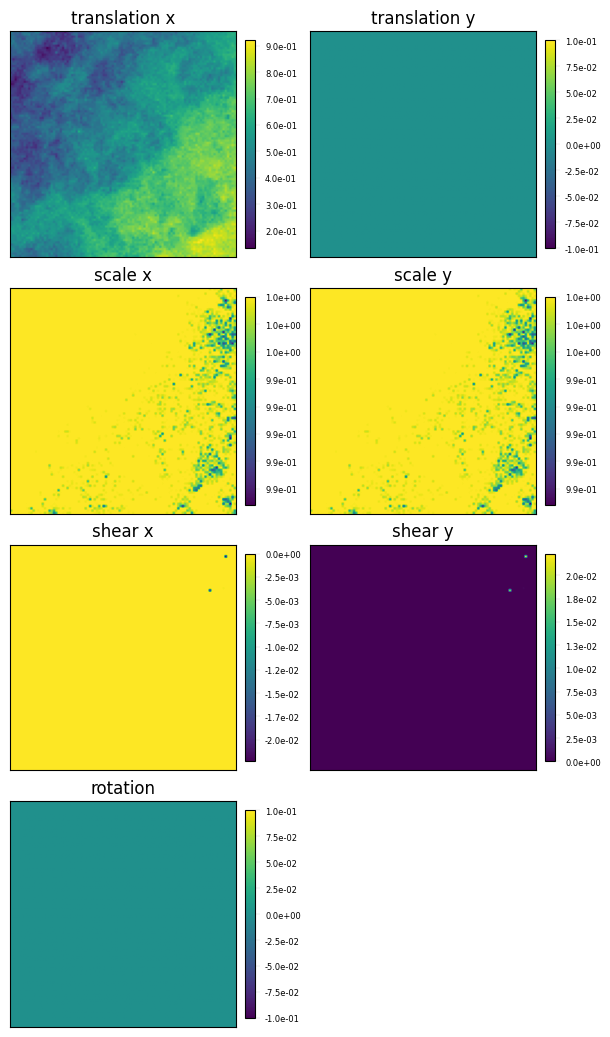

In [48]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    keys=list(h.keys())
    plt.clf();plt.clf()
    affines([ h[keys[2]][:], h[keys[3]][:], h[keys[4]][:], h[keys[1]][:]],
            shape_=[100, 100,176,176], 
            scale=True,
            shear=True,
            trans=True,
            rot=True)

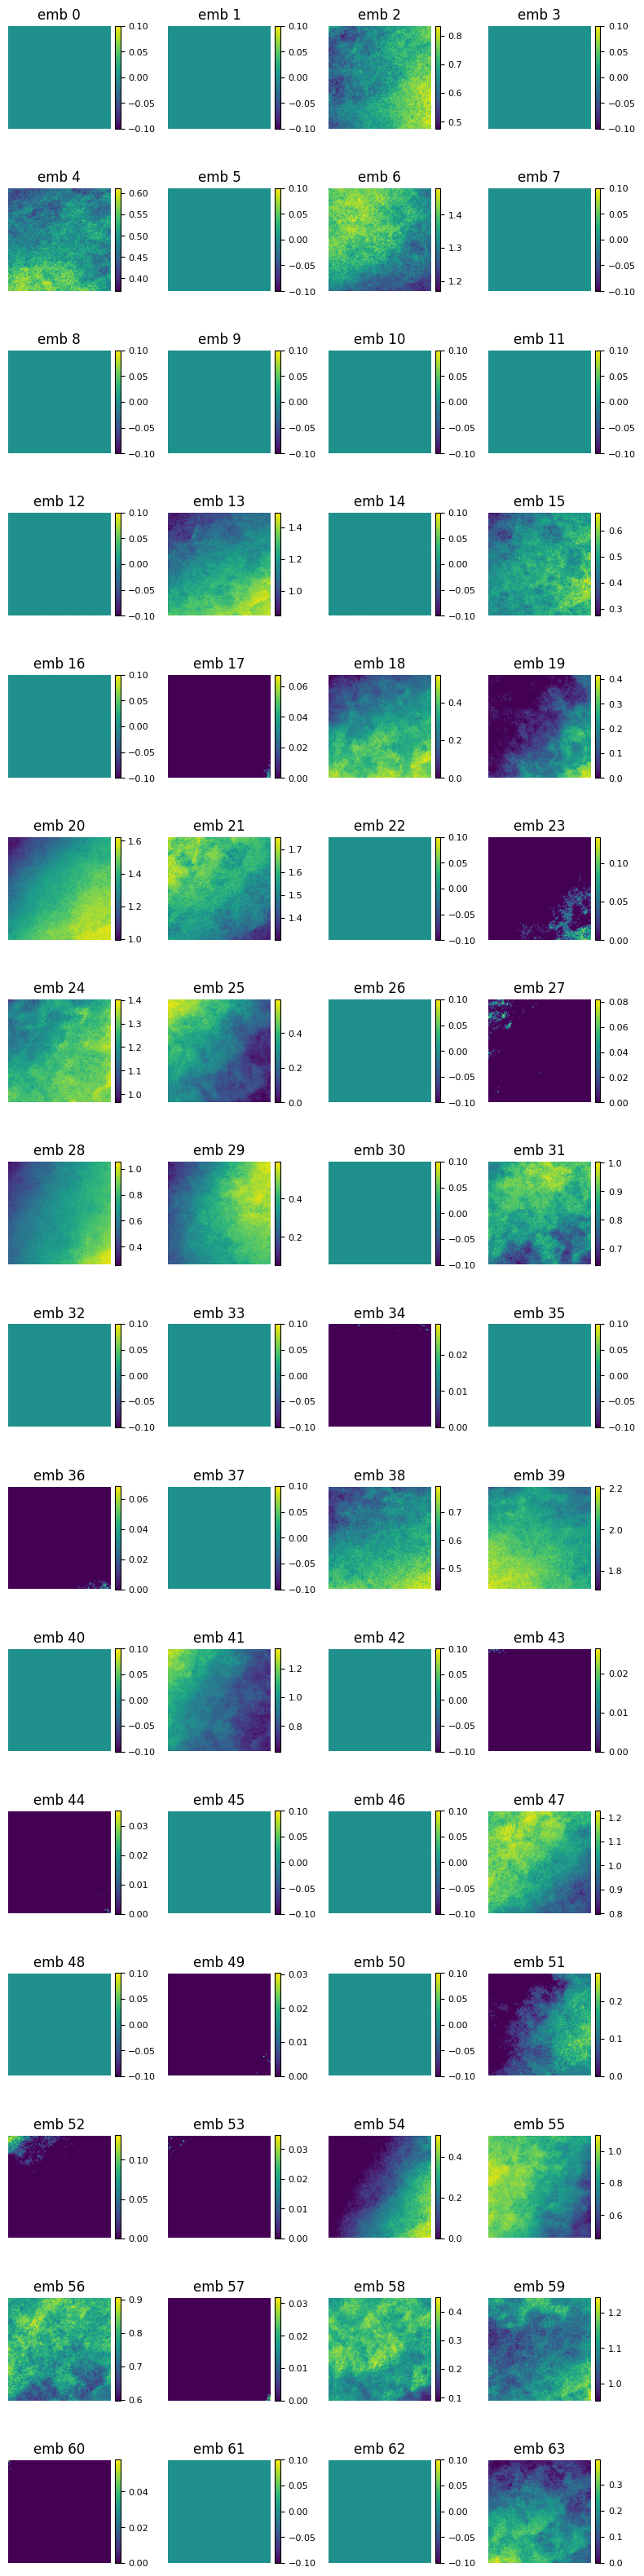

In [49]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    fig, ax = plt.subplots(16, 4, figsize=(8,32))
    ax = ax.flatten()
    for i in range(len(ax)):
        ax[i].axis('off')
        ax[i].set_title(f'emb {i}')
        a = ax[i].imshow(h[keys[0]][:,i].reshape(100,100))
        cbar = plt.colorbar(a, ax=ax[i], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    fig.tight_layout()
    plt.show()

In [38]:
model.folder_path

'/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/2222_pool_rand_k7'

In [39]:
printing = printer(basepath=model.folder_path, fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}


In [50]:
viz.model = model
# channels = [0,2,3,8,9,10,19,25,26,27,30,31]
# channels = [2,3,8,10,21,27,34,37,40,42,44,50,54,55,59]
# channels = [0,2,10,11,13,14,15,17,21,26,28,29,34,37,40,46,47,50,57,62,63] # k5
# channels = [2,3,5,7,8,9,11,12,13,14,18,22,23,24,28,29,30,31,34,35,37,38,39,40,41,42,43,47,48,50,57]
# viz.channels = [i for i in range(32)]
channels = [2,4,6]
folder_name = "0_pool_rand_k5"

model.generate_by_range(
    orig_shape=dataset.shape,
    generator_iters=50,
    averaging_number=50,
    channels=channels,
    )

100%|██████████| 50/50 [00:00<00:00, 77.25it/s]


In [51]:
cmap = plt.colormaps.get_cmap('viridis')

In [52]:

# with h5py.File(model.gen_h5_path, 'r+') as h:
#     # print(h.keys())
#     # gen_data = h['(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001'][0]
#     # del h['(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001']
#     # print(h.keys())
#     # h.create_dataset('(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001', data=gen_data)
#     # print(h.keys())
#     print(h['(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001'].shape)
    

/tmp/ipykernel_1683235/819301921.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', generator_iters)


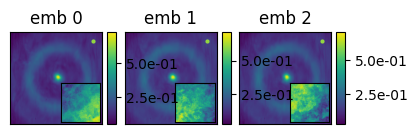

In [53]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import h5py
# which iter
i = 40
shape_ = [100, 100, 176, 176]
generator_iters = 50
cmap = plt.cm.get_cmap('viridis', generator_iters)

fig, ax = layout_fig(len(channels), 4, figsize=(len(channels)*1.5,8))
ax = ax.flatten()
with h5py.File(model.gen_h5_path, 'r+') as h:
    data = h[model.check]
    for j in range(len(channels)):
        with h5py.File(model.emb_h5_path, 'r+') as h_emb: emb = h_emb[f'embedding_{model.check}'][:,channels[j]]
        imagemap(ax[j], data[i,j])    
    
        pt = int(shape_[-1]*0.1)
        ax[j].plot(shape_[-1]-pt-1,pt, marker='o', markeredgewidth=0.0, markersize=3,
                    markerfacecolor=cmap((i+1)/generator_iters))

        axes_in = ax[j].inset_axes([0.55, 0.02, 0.43, 0.43])

        # plots the embedding and formats embedding
        imagemap(axes_in, 
                    emb.reshape(shape_[0],shape_[1]), 
                    colorbars=False)
        ax[j].set_title(f'emb {j}')
    plt.show()

In [ ]:

(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[176,176,100,100,],
    divider_=False,
    graph_layout=[len(viz.channels), 4],
)

In [15]:
# model.Train(dataset.log_data,
#         coef_1=0.,
#         epochs=15,
#         with_scheduler=False,
#         folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/0_pool_rand_k5/",
#         batch_size=32,
# )

## MISC

In [11]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/0_pool_rand_k5/(2024-11-21_17-12-32)_epoch:0000_trainloss:0.0008.pkl' 

model.checkpoint = checkpoint
model.load_weights(checkpoint)

/home/xz498/NaCl_STEM/Gaussian_Sampler/Gaussian_Sampler/models/affine_AE.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_checkpoint)


In [12]:
model.get_embeddings(dataset.log_data, batch_size=64,)

100%|██████████| 157/157 [01:14<00:00,  2.11it/s]


/tmp/ipykernel_1772908/1983059906.py:14: RuntimeWarning: invalid value encountered in arccos
  acos = np.arccos(rotation[:,0])


<Figure size 640x480 with 0 Axes>

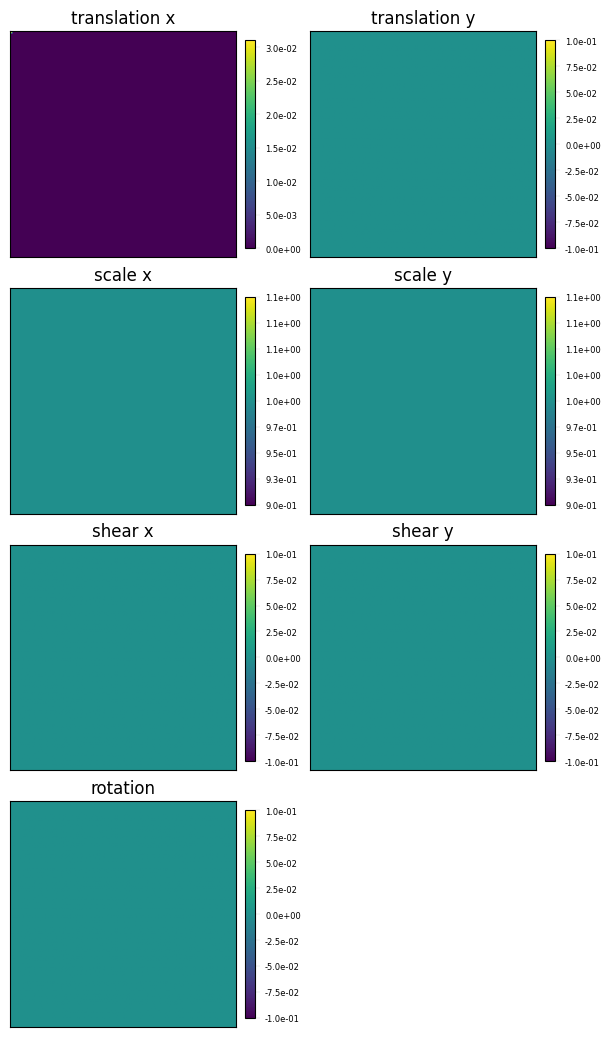

In [13]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    keys=list(h.keys())
    plt.clf();plt.clf()
    affines([ h[keys[2]][:], h[keys[3]][:], h[keys[4]][:], h[keys[1]][:]],
            shape_=[100, 100,176,176], 
            scale=True,
            shear=True,
            trans=True,
            rot=True)

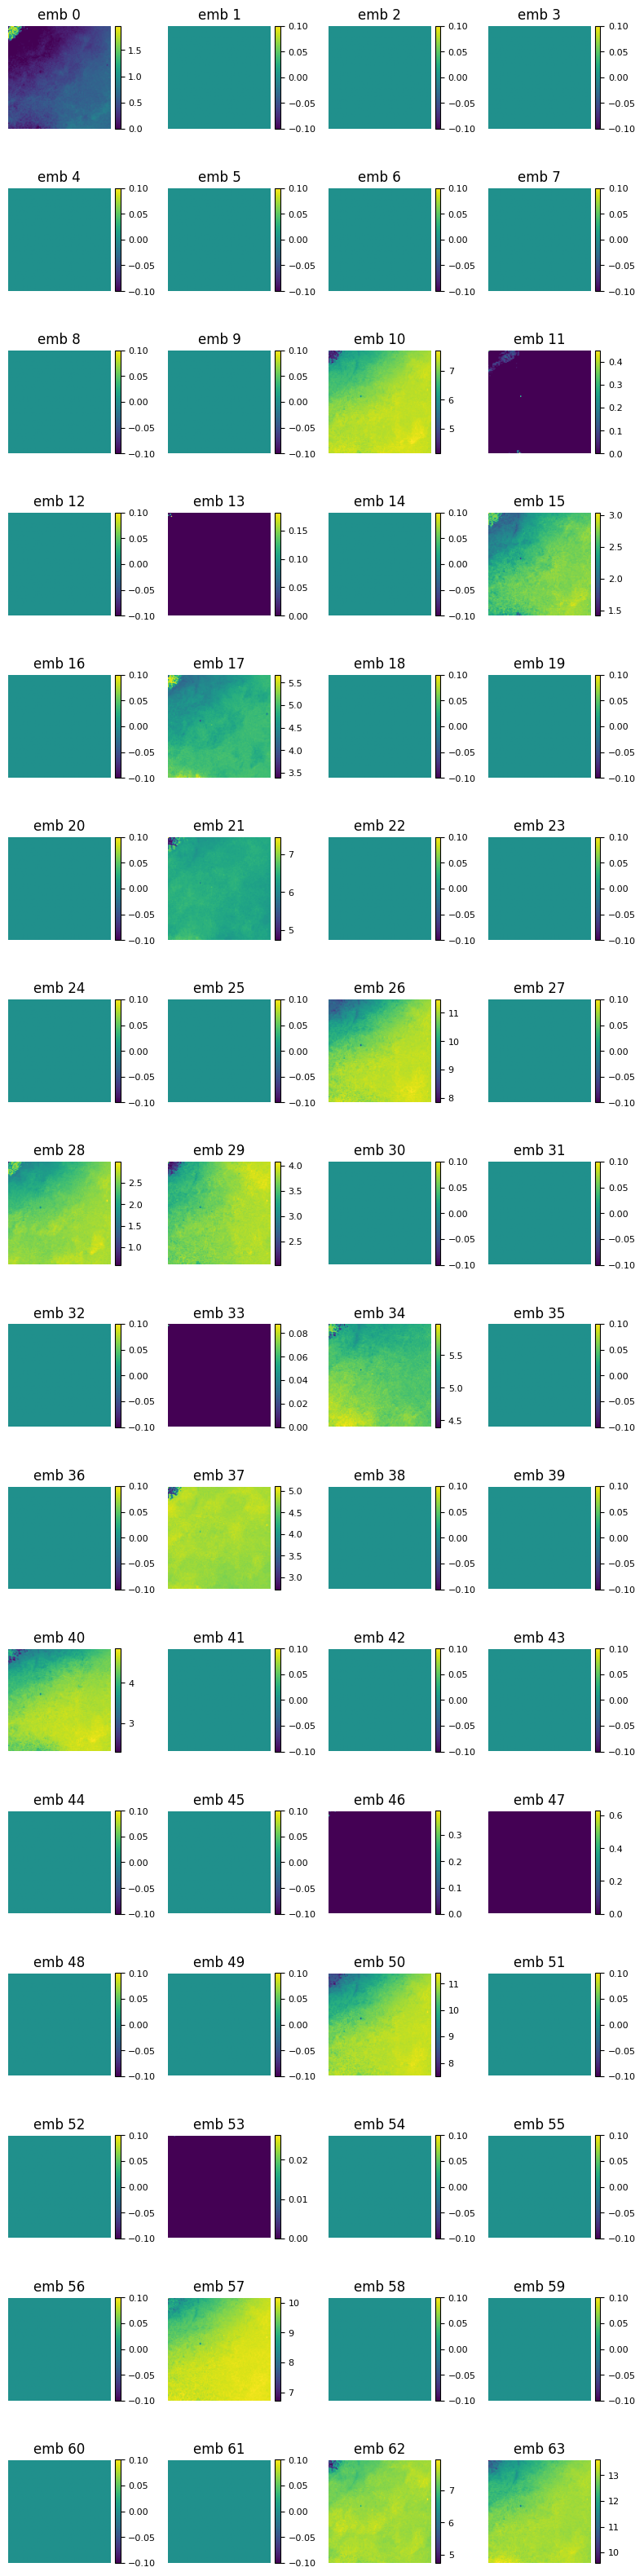

In [14]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    fig, ax = plt.subplots(16, 4, figsize=(8,32))
    ax = ax.flatten()
    for i in range(len(ax)):
        ax[i].axis('off')
        ax[i].set_title(f'emb {i}')
        a = ax[i].imshow(h[keys[0]][:,i].reshape(100,100))
        cbar = plt.colorbar(a, ax=ax[i], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    fig.tight_layout()
    plt.show()

In [15]:
printing = printer(basepath=model.folder_path, fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}


In [16]:
viz.model = model
# channels = [0,2,3,8,9,10,19,25,26,27,30,31]
# channels = [2,3,8,10,21,27,34,37,40,42,44,50,54,55,59]
# channels = [0,2,10,11,13,14,15,17,21,26,28,29,34,37,40,46,47,50,57,62,63]
# viz.channels = [i for i in range(32)]
channels = [56,62,63]
folder_name = "0_pool_rand_k5"

model.generate_by_range(
    orig_shape=dataset.shape,
    generator_iters=50,
    averaging_number=50,
    channels=channels,
    )

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 54.17it/s]


In [17]:
cmap = plt.colormaps.get_cmap('viridis')

In [35]:
from torch.utils.data import DataLoader
loader = DataLoader(dataset.log_data, batch_size=1, shuffle=False)

/tmp/ipykernel_1772908/1007294308.py:8: UserWarning: Using a target size (torch.Size([1, 176, 176])) that is different to the input size (torch.Size([1, 1, 176, 176])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  fig.suptitle(f'{mse_loss(x, batch.float().to("cuda:3"))}')
/tmp/ipykernel_1772908/1007294308.py:8: UserWarning: Using a target size (torch.Size([1, 176, 176])) that is different to the input size (torch.Size([1, 1, 176, 176])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  fig.suptitle(f'{mse_loss(x, batch.float().to("cuda:3"))}')
/tmp/ipykernel_1772908/1007294308.py:8: UserWarning: Using a target size (torch.Size([1, 176, 176])) that is different to the input size (torch.Size([1, 1, 176, 176])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  fig.suptitle(f'{mse_loss(x, batch.float().to("cuda:3"))}')
/

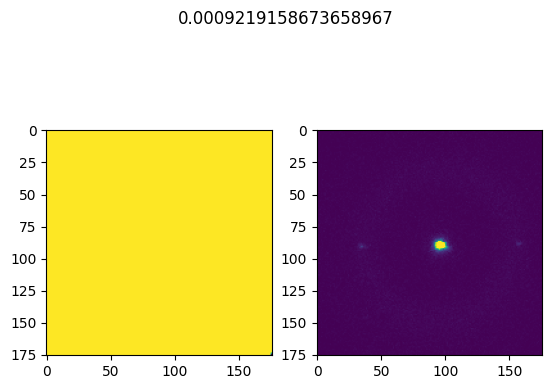

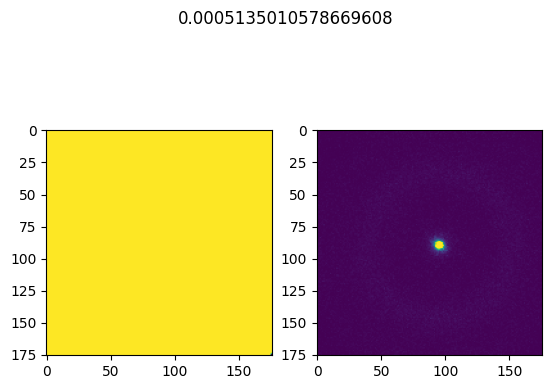

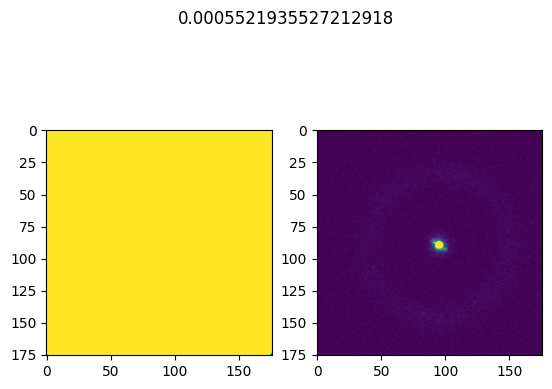

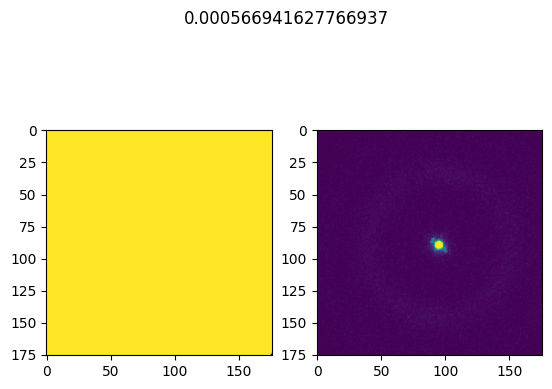

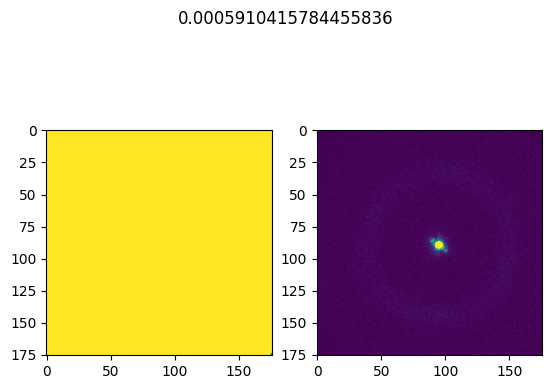

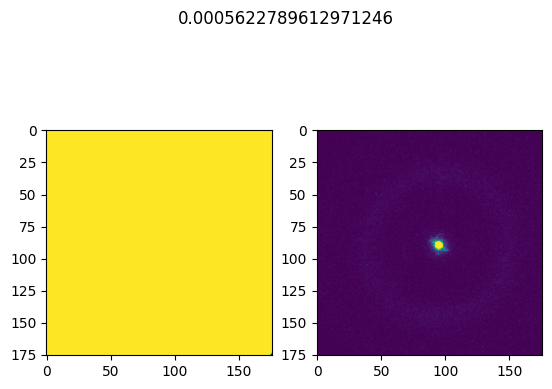

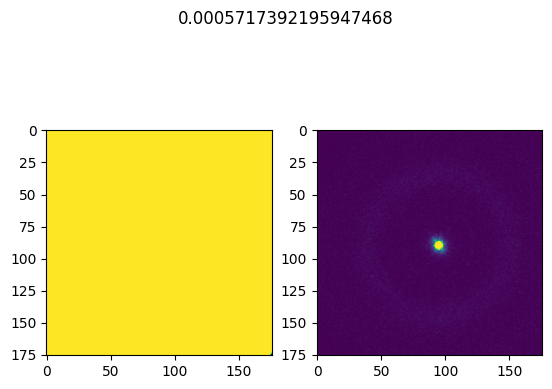

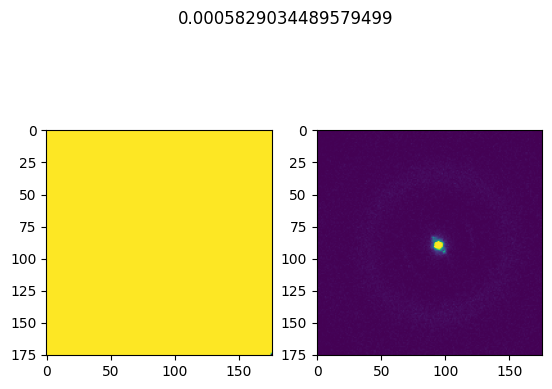

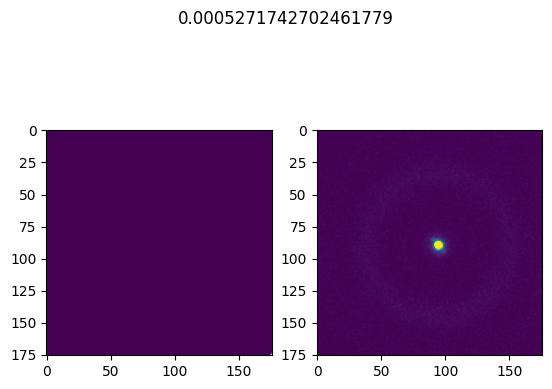

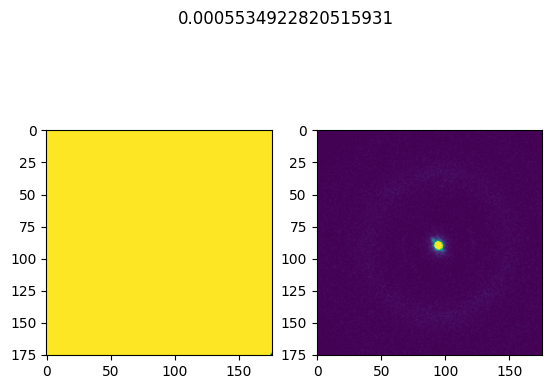

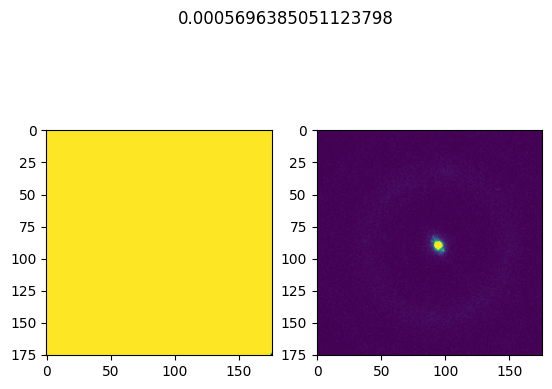

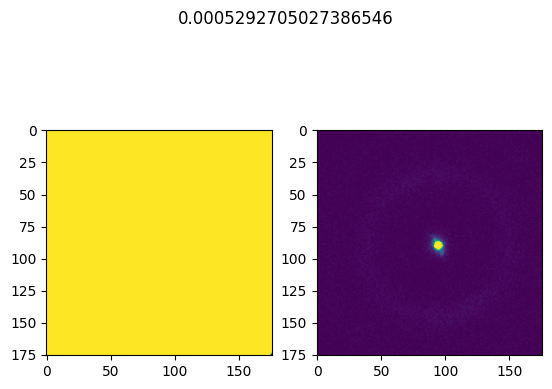

In [45]:
from torch.nn.functional import mse_loss
for i,batch in enumerate(loader):
    x, emb, translation, rotation, scale, shear, mask_parameter = model.autoencoder(batch.float().to('cuda:3'))
    
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(x.cpu().detach().numpy().reshape(176,176))
    ax[1].imshow(batch.cpu().detach().numpy().reshape(176,176))
    fig.suptitle(f'{mse_loss(x, batch.float().to("cuda:3"))}')
    
    if i >10: break
# batch = next(iter(loader))
# x, emb, translation, rotation, scale, shear, mask_parameter = model.autoencoder(batch.float().to('cuda:3'))
# print(mse_loss(x, batch.float().to('cuda:3')))

In [38]:
import torch
from torch.nn.functional import mse_loss
batch = next(iter(loader))
loss = mse_loss(x, batch.float().to('cuda:3'))
print(loss)

tensor(0.0009, device='cuda:3', grad_fn=<MseLossBackward0>)


/tmp/ipykernel_1772908/3326574787.py:4: UserWarning: Using a target size (torch.Size([1, 176, 176])) that is different to the input size (torch.Size([1, 1, 176, 176])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = mse_loss(x, batch.float().to('cuda:3'))


/tmp/ipykernel_1772908/581065749.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', generator_iters)


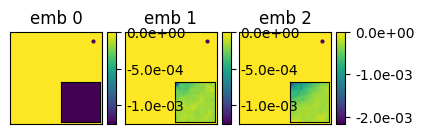

In [19]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import h5py
# which iter
i = 0
shape_ = [100, 100, 176, 176]
generator_iters = 50
cmap = plt.cm.get_cmap('viridis', generator_iters)

fig, ax = layout_fig(len(channels), 4, figsize=(len(channels)*1.5,8))
ax = ax.flatten()
with h5py.File(model.gen_h5_path, 'r+') as h:
    data = h[model.check]
    for j in range(len(channels)):
        with h5py.File(model.emb_h5_path, 'r+') as h_emb: emb = h_emb[f'embedding_{model.check}'][:,channels[j]]
        imagemap(ax[j], data[i,j])    
    
        pt = int(shape_[-1]*0.1)
        ax[j].plot(shape_[-1]-pt-1,pt, marker='o', markeredgewidth=0.0, markersize=3,
                    markerfacecolor=cmap((i+1)/generator_iters))

        axes_in = ax[j].inset_axes([0.55, 0.02, 0.43, 0.43])

        # plots the embedding and formats embedding
        imagemap(axes_in, 
                    emb.reshape(shape_[0],shape_[1]), 
                    colorbars=False)
        ax[j].set_title(f'emb {j}')
    plt.show()

In [ ]:

(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[176,176,100,100,],
    divider_=False,
    graph_layout=[len(viz.channels), 4],
)

## Train with Gaussian Sampling

<!-- ### sampler -->

In [ ]:
sampler = Gaussian_Sampler(dset = dataset,
                           orig_shape = dataset.data.shape,
                           batch_size = 64,
                           gaussian_std = 2,
                           num_neighbors = 16)

In [ ]:
from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler, custom_collate_fn
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset,
                        sampler = sampler,
                        collate_fn = custom_collate_fn)


In [ ]:
next(iter(dataloader)).shape

In [ ]:
# import numpy as np
# colors = 'red, orange, yellow, green, blue, purple, pink, brown, gray, black'.split(', ')
# plt.clf(); plt.clf()
# plt.imshow(dataset.log_data.mean(axis=(1,2)).reshape(dataset.data.shape[:2]))
# plt.colorbar()
# for i,col in enumerate(colors):
#     sample = next(iter(sampler))
#     coords = np.array([[sam//dataset.data.shape[0], sam%dataset.data.shape[0]] for sam in sample])
#     plt.scatter(coords[:,0],coords[:,1],s=3,color=col,)
# plt.show()

In [ ]:
from Gaussian_Sampler.models.affine_AE import Affine_AE_2D, Affine_Transform, Affine_AE_2D_module
from m3_learning.nn.STEM_AE import STEM_AE


<!-- ### shallow -->

In [ ]:
# try with and without interpolation
model = Affine_AE_2D(device='cuda:3',
                     sampler=Gaussian_Sampler,
                     sampler_kwargs={'dset': dataset,
                                     'orig_shape': dataset.data.shape,
                                     'batch_size': 16,
                                     'gaussian_std': 2,
                                     'num_neighbors': 16},
                     collate_fn=custom_collate_fn,
                     
                     affine_encoder = STEM_AE.Encoder,
                     affine_encoder_kwargs = { 'original_step_size': [176,176], 
                                               'pooling_list': [2,2], 
                                               'embedding_size': 6, # translation, rotation, xscale, yscale, xshear, yshear,
                                               'conv_size': 128,
                                            #    'kernel_size': 3,
                                               },
                     
                     affine_module = Affine_Transform,
                     affine_kwargs = {  "scale": True,
                                        "shear": True,
                                        "rotation": True,
                                        "translation": True,
                                        "Symmetric": True,
                                        "mask_intensity": False,
                                        "scale_limit": 0.05,
                                        "shear_limit": 0.1,
                                        "rotation_limit": 0.1,
                                        "trans_limit": 0.15,
                                        "adj_mask_para": 0  
                                        },
                     
                     encoder = STEM_AE.Encoder,
                     encoder_kwargs = { 'original_step_size': [176,176], 
                                        'pooling_list': [2,2], 
                                        'embedding_size': 32, # translation, rotation, xscale, yscale, xshear, yshear,
                                        'conv_size': 128,
                                        # 'kernel_size': 3,
                                        },
                
                    decoder = STEM_AE.Decoder,
                    decoder_kwargs = { 'original_step_size': [8,8], 
                                        'upsampling_list': [11,2], 
                                        'embedding_size': 32, 
                                        'conv_size': 128,
                                        'pooling_list': [2,2], 
                                        # 'kernel_size': 3,
                                        },
                    autoencoder = Affine_AE_2D_module,
                     
                     # STEM AE kwargs:
                     encoder_step_size=[176, 176],
                     pooling_list=[4],
                     decoder_step_size=[22, 22],
                     upsampling_list=[8],
                     embedding_size=32,
                     conv_size=128,
                    #  device='cuda:1',
                     learning_rate=3e-5
                    )

In [ ]:
# model.Train(dataset.log_data,
#         coef_1=0.,
#         epochs=10,
#         with_scheduler=False,
#         folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/4_9/"
# )

In [ ]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/4_9/(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001.pkl'
model.checkpoint = checkpoint
model.load_weights(checkpoint)

In [ ]:
# model.get_embeddings(dataset.log_data)

In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model)

In [ ]:
emb, scale, shear, rotation, translation = embedding[0]

In [ ]:
keys = ['embedding_(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001', 'rotation_(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001', 'scale_(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001', 'shear_(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001', 'translation_(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001']

In [ ]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    fig, ax = plt.subplots(8, 4, figsize=(8,16))
    ax = ax.flatten()
    for i in range(len(ax)):
        ax[i].axis('off')
        ax[i].set_title(f'emb {i}')
        a = ax[i].imshow(h[keys[0]][:,i].reshape(100,100))
        cbar = plt.colorbar(a, ax=ax[i], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    fig.tight_layout()
    plt.show()

In [ ]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import numpy as np

plt.clf();plt.clf()
def get_theta(rotation):
    """_summary_

    Args:
        rotation (array-like): (n,2,3) affine matrix reshapeed into (n,6)

    Returns:
        float: _description_
    """    
    acos = np.arccos(rotation[:,0])
    asin = np.arcsin(rotation[:,1])
    theta = asin.copy()

    # asin(+), acos(+) means the angle is accurate
    # asin(-), acos(-) means 3rd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] *= -1 
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] += -np.pi
    # asin(+), acos(-) means 2nd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] *= -1
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] += np.pi/2
    
    return theta

def affines(affines,
            shape_=[255, 256, 256, 256], 
            sc=True,
            sh=True,
            trans=True,
            rot=True,
            name="",
            labelfigs_ = False,
            scalebar_ = None,
            printer = None,
            **kwargs):
    """Plots the embeddings

    Args:
        embedding (tuple of array-like): (scale_shear,rotation,translation) matrices from AffineTransform class.
                                         If not calculated, put None.
        # mod (int, optional): defines the number of columns in the figure. Defaults to 4.
        channels (bool, optional): specific channels to plot. Defaults to False.
        scalebar_ (dict, optional): add the scalebar. Defaults to None.
        shape_ (list, optional): shape of the initial image. Defaults to [265, 256, 256, 256].
        name (str, optional): filename. Defaults to "".
        channels (bool, optional): _description_. Defaults to False.
        labelfigs_ (bool, optional): _description_. Defaults to False.
        add_scalebar (_type_, optional): _description_. Defaults to None.
        printer (_type_, optional): _description_. Defaults to None.
    """        

    scale,shear,rotation,translation = affines

    # # sets the channels to use in the object
    # if channels is None:
    #     channels = range(7)

    num_plots = 2*sh + 2*sc + 2*trans + rot
    # builds the figure
    fig, axs = layout_fig(num_plots, mod=2, **kwargs)

    i=0
    # translation
    if trans:
        imagemap(axs[i], translation[:,2].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], translation[:,5].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('translation x')
        axs[i+1].set_title('translation y')
        i+=2
    # scale_shear
    if sc:
        imagemap(axs[i], scale[:,0].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], scale[:,4].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('scale x')
        axs[i+1].set_title('scale y')
        i+=2
    if sh:
        imagemap(axs[i], shear[:,1].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear x
        imagemap(axs[i+1], shear[:,3].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear y
        axs[i].set_title('shear x')
        axs[i+1].set_title('shear y')
        i+=2
    # rotation
    if rot:
        theta = get_theta(rotation)
        # lim = abs(theta.mean())+abs(3*theta.std())
        imagemap(axs[i], theta.reshape(shape_[-4], shape_[-3]), 
                 divider_=False,**kwargs) # rotation angle
        axs[i].set_title('rotation')

    # adds labels to the figure
    if labelfigs_:
        for i, ax in enumerate(axs):
            labelfigs(ax, i)

    # adds the scalebar
    if scalebar_ is not None:
        add_scalebar(axs.flatten()[-1], scalebar_)

    # prints the image
    if printer is not None:
        printer.savefig(fig,
            f'{name}_affine_maps', tight_layout=False)
        
    # plt.close(fig)
    # return fig, ax


In [ ]:
with h5py.File(model.emb_h5_path, 'r+') as h:
    plt.clf();plt.clf()
    affines([ h[keys[2]][:], h[keys[3]][:], h[keys[4]][:], h[keys[1]][:]],
            shape_=[100, 100,176,176], 
            scale=True,
            shear=True,
            trans=True,
            rot=True)

In [ ]:
printing = printer(basepath=file_path_output+'affine/viz_4_9/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}


In [ ]:
dataset.shape

In [ ]:
viz.model = model
channels = [0,2,3,8,9,10,19,25,26,27,30,31]
# viz.channels = [i for i in range(32)]
folder_name = "4_9_"

model.generate_by_range(
    orig_shape=dataset.shape,
    generator_iters=50,
    averaging_number=50,
    channels=channels,
    )

In [ ]:
cmap = plt.colormaps.get_cmap('viridis')
cmap

In [ ]:
cmap(0.5)

In [ ]:

with h5py.File(model.gen_h5_path, 'r+') as h:
    # print(h.keys())
    # gen_data = h['(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001'][0]
    # del h['(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001']
    # print(h.keys())
    # h.create_dataset('(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001', data=gen_data)
    # print(h.keys())
    print(h['(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001'].shape)
    

In [ ]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import h5py
# which iter
i = 49

shape_ = [100, 100, 176, 176]
generator_iters = 50
cmap = plt.cm.get_cmap('viridis', generator_iters)

fig, ax = layout_fig(len(channels), 4, figsize=(len(channels)*1.5,8))
ax = ax.flatten()
with h5py.File(model.gen_h5_path, 'r+') as h:
    data = h[model.check]
    for j in range(len(channels)):
        with h5py.File(model.emb_h5_path, 'r+') as h_emb: emb = h_emb[f'embedding_{model.check}'][:,channels[j]]
        imagemap(ax[j], data[i,j])    
    
        pt = int(shape_[-1]*0.1)
        ax[j].plot(shape_[-1]-pt-1,pt, marker='o', markeredgewidth=0.0, markersize=3,
                    markerfacecolor=cmap((i+1)/generator_iters))

        axes_in = ax[j].inset_axes([0.55, 0.02, 0.43, 0.43])

        # plots the embedding and formats embedding
        imagemap(axes_in, 
                    emb.reshape(shape_[0],shape_[1]), 
                    colorbars=False)
        ax[j].set_title(f'emb {j}')
    plt.show()

In [ ]:

(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[176,176,100,100,],
    divider_=False,
    graph_layout=[len(viz.channels), 4],
)

<!-- ### 2 pooling/ upsampling -->

In [ ]:
model = Averaging_Loss_AE(sampler = Gaussian_Sampler,
                          sampler_kwargs = {'dset': dataset,
                                            'orig_shape': dataset.data.shape,
                                            'batch_size': 64,
                                            'gaussian_std': 2,
                                            'num_neighbors': 16},
                          collate_fn = custom_collate_fn,
                          # STEM AE kwargs:
                          encoder_step_size = [176,176],
                          pooling_list = [2,2],
                          decoder_step_size = [22,22],
                          upsampling_list = [2,4],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)


In [ ]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs=5,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4/",
        dataloader_init = {'sampler': sampler,
                           'collate_fn': custom_collate_fn}
)

In [ ]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax_thresh/2_2_3_3/Weight_epoch:0004_l1coef:0.0000_lr:0.00003_trainloss:0.4968.pkl'
model.load_weights(checkpoint)

In [ ]:
embeddings = model.get_embedding(dataset.log_data,batch_size=100)

In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [ ]:
printing = printer(basepath=file_path_output+'11_13_cropped_centered/viz_2_2_2_4/', fileformats=["png"]) # was wrong folder name!
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

In [ ]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_2_4"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[176,176,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

<!-- ### 2 pooling/ upsampling kernel 5 -->

In [ ]:
model = Averaging_Loss_AE(sampler = Gaussian_Sampler,
                          sampler_kwargs = {'dset': dataset,
                                            'orig_shape': dataset.data.shape,
                                            'batch_size': 64,
                                            'gaussian_std': 2,
                                            'num_neighbors': 16},
                          collate_fn = custom_collate_fn,
                          # STEM AE kwargs:
                          encoder_step_size = [216,216],
                          pooling_list = [2,2],
                          decoder_step_size = [24,24],
                          upsampling_list = [3,3],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          kernel_size = 5,
                          learning_rate=3e-5,)


In [ ]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs=5,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax_thresh/2_2_3_3_k5/",
        dataloader_init = {'sampler': sampler,
                           'collate_fn': custom_collate_fn}
)

In [ ]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3/Weight_epoch:0018_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl'
model.load_weights(checkpoint)

In [ ]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [ ]:
printing = printer(basepath=file_path_output+'minmax_thresh/viz_2_2_3_3/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

In [ ]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

<!-- ### 2 pooling/ upsampling l1 scheduling -->

In [ ]:
model = Averaging_Loss_AE(sampler = Gaussian_Sampler,
                          sampler_kwargs = {'dset': dataset,
                                            'orig_shape': dataset.data.shape,
                                            'batch_size': 64,
                                            'gaussian_std': 4,
                                            'num_neighbors': 8},
                          collate_fn = custom_collate_fn,
                          # STEM AE kwargs:
                          encoder_step_size = [216,216],
                          pooling_list = [2,2],
                          decoder_step_size = [24,24],
                          upsampling_list = [3,3],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)


In [ ]:
for ep in range(25):
    model.Train(dataset.log_data,
            coef_1=(ep//5)*1e-3,
            epoch_=ep,
            epochs=1,
            with_scheduler=False,
            folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/2_2_3_3_l1_scheduling/",
            dataloader_init = {'sampler': sampler,
                               'collate_fn': custom_collate_fn}
    )

In [ ]:
# shallow
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_l1_scheduling/Weight_epoch:0000_l1coef:0.0040_lr:0.00003_trainloss:0.4971.pkl'

model.load_weights(checkpoint)

In [ ]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [ ]:
printing = printer(basepath=file_path_output+'minmax/viz_2_2_3_3_l1_scheduling/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

In [ ]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_l1_scheduling_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    generator_iters=100,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

<!-- ### 2 pooling/ upsampling contr loss -->

In [ ]:
model = Averaging_Loss_AE(sampler = Gaussian_Sampler,
                          sampler_kwargs = {'dset': dataset,
                                            'orig_shape': dataset.data.shape,
                                            'batch_size': 64,
                                            'gaussian_std': 4,
                                            'num_neighbors': 8},
                          collate_fn = custom_collate_fn,
                          # STEM AE kwargs:
                          encoder_step_size = [216,216],
                          pooling_list = [2,2],
                          decoder_step_size = [24,24],
                          upsampling_list = [3,3],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)

In [ ]:
for ep in range(25):
    model.Train(dataset.log_data,
            coef_2=(ep//5)*1e-3,
            epoch_=ep,
            epochs=1,
            with_scheduler=False,
            folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/2_2_3_3_contr_scheduling/",
            dataloader_init = {'sampler': sampler,
                               'collate_fn': custom_collate_fn}
    )

In [ ]:
# shallow
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_contr_scheduling/Weight_epoch:0000_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl' 

model.load_weights(checkpoint)

In [ ]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [ ]:
printing = printer(basepath=file_path_output+'minmax/viz_2_2_3_3_contr_scheduling/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

In [ ]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_contr_scheduling_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    generator_iters=100,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

<!-- ### 2 pooling/ upsampling l1 sched contr loss -->

In [ ]:
model = Averaging_Loss_AE(sampler = Gaussian_Sampler,
                          sampler_kwargs = {'dset': dataset,
                                            'orig_shape': dataset.data.shape,
                                            'batch_size': 64,
                                            'gaussian_std': 4,
                                            'num_neighbors': 8},
                          collate_fn = custom_collate_fn,
                          # STEM AE kwargs:
                          encoder_step_size = [216,216],
                          pooling_list = [2,2],
                          decoder_step_size = [24,24],
                          upsampling_list = [3,3],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)


In [ ]:
for ep in range(25):
    model.Train(dataset.log_data,
            epoch_=ep,
            coef_1=(ep//5)*1e-3,
            coef_2=(ep//5)*1e-3,
            epochs=1,
            with_scheduler=False,
            folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_l1_contr_scheduling/",
            dataloader_init = {'sampler': sampler,
                               'collate_fn': custom_collate_fn}
    )

In [ ]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_l1_contr_scheduling/Weight_epoch:0000_l1coef:0.0040_lr:0.00003_trainloss:0.4971.pkl' 

model.load_weights(checkpoint)

In [ ]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [ ]:
viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    name="ep_40",
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

In [ ]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_l1_contr_scheduling"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    generator_iters=100,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

<!-- ### Movie -->

In [ ]:
from m3_learning.viz.Movies import make_movie

# Builds a Movie
folder = f"/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_gauss/"
output_folder = "./movies/"

# function to make the movie
make_movie(f"{data_id}_ep_40_gauss", folder, output_folder, "png", 3)



<!-- ## Train with regular sampling -->

<!-- ### 2 pooling/ upsampling -->

In [ ]:
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder
model = ConvAutoencoder(# STEM AE kwargs:
                          encoder_step_size = [176,176],
                          pooling_list = [2,2],
                          decoder_step_size = [22,22],
                          upsampling_list = [2,4],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)


In [ ]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs=5,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/",
)

In [ ]:
# checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3/Weight_epoch:0018_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl'
# model.load_weights(checkpoint)

In [ ]:
embeddings = model.get_embedding(dataset.log_data,batch_size=100)

In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [ ]:
printing = printer(basepath=file_path_output+'11_13_cropped_centered/2_2_2_4_rand_/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}
viz.channels = None

model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_2_4_rand"


In [ ]:
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

In [ ]:
viz.generator_images(
    folder_name=folder_name,
    figsize=(8,12),
    cbar_number_format="%.1e",
    shape_=[176,176,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 8],
)

In [ ]:
from m3_learning.viz.Movies import make_movie

# Builds a Movie
folder = f"{printing.basepath}/generator_images_{folder_name}/"
output_folder = f"{printing.basepath}/"

# function to make the movie
make_movie(f"6.1: {data_id}_blocked_centered_removehot_nolog_standardax0_minmax", folder, output_folder, "png", 3)


<!-- ### 2 pooling/ upsampling kernel 5 -->

In [ ]:
model = ConvAutoencoder(# STEM AE kwargs:
                          encoder_step_size = [176,176],
                          pooling_list = [2,2],
                          decoder_step_size = [22,22],
                          upsampling_list = [2,4],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          kernel_size = 5,
                          learning_rate=3e-5,)

In [ ]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs=5,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax_thresh/2_2_3_3_k5/",
        dataloader_init = {'sampler': sampler,
                           'collate_fn': custom_collate_fn}
)

In [ ]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3/Weight_epoch:0018_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl'
model.load_weights(checkpoint)

In [ ]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [ ]:
printing = printer(basepath=file_path_output+'minmax_thresh/viz_2_2_3_3/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

In [ ]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

<!-- ### 2 pooling/ upsampling contr loss -->

In [ ]:
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder
model = ConvAutoencoder(# STEM AE kwargs:
                          encoder_step_size = [176,176],
                          pooling_list = [2,2],
                          decoder_step_size = [22,22],
                          upsampling_list = [2,4],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)

In [ ]:
for ep in range(5):
    model.Train(dataset.log_data,
            coef_2=(ep/5)*1e-4,
            epoch_=ep,
            epochs=ep+2,
            with_scheduler=False,
            folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_3_3_contr_scheduling/",
    )

In [ ]:
# shallow
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_contr_scheduling/Weight_epoch:0000_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl' 

model.load_weights(checkpoint)


In [ ]:
embeddings = model.get_embedding(dataset.log_data,batch_size=100)

In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [ ]:
printing = printer(basepath=file_path_output+'11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

In [ ]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_contr_scheduling_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[176,176,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

<!-- ### 2 pooling/ upsampling contr loss -->

In [ ]:
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder
model = ConvAutoencoder(# STEM AE kwargs:
                          encoder_step_size = [176,176],
                          pooling_list = [2,2],
                          decoder_step_size = [22,22],
                          upsampling_list = [2,4],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)

In [ ]:
for ep in range(5):
    model.Train(dataset.log_data,
            coef_2=(ep/5)*1e-4,
            epoch_=ep,
            epochs=ep+2,
            with_scheduler=False,
            folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_3_3_contr_scheduling/",
    )

In [ ]:
# shallow
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_contr_scheduling/Weight_epoch:0000_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl' 

model.load_weights(checkpoint)

In [ ]:
embeddings = model.get_embedding(dataset.log_data,batch_size=100)

In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [ ]:
printing = printer(basepath=file_path_output+'11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

In [ ]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_contr_scheduling_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[176,176,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

<!-- ### misc -->


In [ ]:
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder

model = ConvAutoencoder(encoder_step_size = [216,216],
                        pooling_list = [2,2,2],
                        decoder_step_size = [8,8],
                        upsampling_list = [3,3,3],
                        embedding_size = 24,
                        conv_size = 128,
                        device = 'cuda:1',
                        learning_rate=3e-5,)

In [ ]:
model.Train(dataset.data,
        coef_1=1e-5,
        epoch_=1,
        epochs=100,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7_Rand_Sampling/",
)

<!-- ### load embedding -->

In [ ]:
# ep 95
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7_Rand_Sampling/Weight_epoch:0094_l1coef:0.0000_lr:0.00003_trainloss:0.0003.pkl' 

# # ep 40
# checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7_Gauss_Sampling/Weight_epoch:0039_l1coef:0.0000_lr:0.00003_trainloss:0.0003.pkl'

model.load_weights(checkpoint)

In [ ]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

<!-- ### Visualize embedding -->

In [ ]:
viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    name="ep_40_rand",
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)


<!-- ### generate -->

In [ ]:
model.embedding = embeddings
viz.model = model
viz.channels = [i for i in range(24)]
folder_name = "ep_40_rand"

viz.generator_images(
    folder_name=folder_name,
    figsize=(9,6),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    averaging_number=50,
    graph_layout=[24, 4],
)

In [ ]:
from m3_learning.viz.Movies import make_movie

# Builds a Movie
folder = f"/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/"
output_folder = "./movies/"

# function to make the movie
make_movie(f"{data_id}_ep_40_rand", folder, output_folder, "png", 3)

